# GTI771 - Apprentissage machine avancé
## Département de génie logiciel et des technologies de l’information (LogTI)

## Laboratoire 1 - Préparation des données
#### <font color=black> Version 1 - Janvier 2025 - Chargé de lab. Arthur Josi </font>

Les laboratoires sont à faire par groupe de deux ou trois étudiants. Favorisez les groupes de trois.

| NOMS           | CODE PERMANENT |
|----------------|----------------|
| Léo Fornoff    | FORL86360209   |
| Zacharie Morin | MORZ63310201   |
| Raphael Roumat | ROUR79040002   |

# Introduction

Ce premier laboratoire porte sur la préparation de données pour l'apprentissage machine, et l'application d'approche simple de classification. Le problème qui vous est présenté est le problème de fraude bancaire [Bank Account Fraud (NeurIPS 2022)](https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022), dont le but est de detecter les fraudes !

Le dataset a été légèrement modifier pour atteindre les objectifs des différents laboratoire et rendre l'application d'algorithme plus rapide.

Veuillez noter que les données qui vous sont fournies ne sont pas directement adaptées à leur analyse. Une approche naïve où l'on appliquerait un algorithme d'apprentissage machine sans analyse des données au préalable est toujours à éviter, et ceci inclus les laboratoires de ce cours. Au cours de ce premier laboratoire, nous allons donc explorer les données, les préparer, et appliquer une méthode de "template matching" pour déterminer si une transaction est une fraude ou non.


Au cours de chacun des laboratoires, l'évaluation sera basée sur:
- les réponses aux questions du notebook;
- la justification et pertinence des algorithmes proposés et utilisés ;
- l'organisation de votre code source (SVP, pensez à commenter votre code source);


# Modules et bibliotèques python

### Import de bibliotèques

Ajouter une courte description aux bibliothèques que vous allez utiliser pour compléter ce notebook. N'hésitez pas à importer celles qui vous sont utiles.

In [17]:
# %pip install pandas seaborn matplotlib scikit-learn
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, pairwise_distances, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Partie 1 - Analyse exploratoire des données

On va commencer par regarder les données, c'est une pratique indispensable.

Pour ce lab, nous allons utiliser le dataset Bank Account Fraud (BAF). **La version à utiliser est celle du moodle.**



###  <font color=blue> Questions: </font>

1. Loader le dataset depuis le fichier csv (en utilisant la librairie [pandas](https://pandas.pydata.org/docs/getting_started/index.html#getting-started) par exemple) et afficher le tableau de données. Si vous mettez vos données dans google colab, vous pouvez normalement y accéder au path: `/content/BAF_200k.csv`.

In [2]:
dataset = df = pd.read_csv('BAF_200k.csv')
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
0,0,0.1,0.218119,110,7,20,0.015684,-1.013463,AD,687,...,28,0,500.0,0,INTERNET,15.611467,windows,1,1,7
1,0,0.1,0.373086,29,7,20,0.024277,19.342285,AA,1230,...,22,0,200.0,0,INTERNET,5.911984,other,0,1,0
2,0,0.2,0.515218,-1,64,20,0.015865,-1.333985,AB,2045,...,25,1,200.0,0,INTERNET,4.732999,other,1,1,4
3,0,0.6,0.899345,-1,56,20,0.018821,-1.524424,AC,1260,...,-1,0,200.0,0,INTERNET,8.210518,linux,1,1,3
4,0,0.9,0.794648,-1,64,50,0.027359,-1.254528,AB,1643,...,1,0,200.0,0,INTERNET,5.131610,other,0,1,0


2. Combien y a-t-il de catégories et quel est le nombre de données (nombre de transactions) dans ce dataset ?

In [3]:
# Code si besoin
print(f"nombre de colonnes {df.shape[1]} (objectif compris)")
print(f"nombre de données {df.shape[0]}")

nombre de colonnes 31 (objectif compris)
nombre de données 200000


Nombre de catégories: 31 avec l'objectif

Nombre de données: 200000

3. Afficher dans un graphe en baton (par exemple avec la librairie [matplotlib](https://matplotlib.org/) ou [seaborn](https://seaborn.pydata.org/)) le nombre de transactions étant des fraudes et celles n'en étant pas. Qu'est-ce que ce graphe vous permet d'observer ? Proposer une réponse courte.

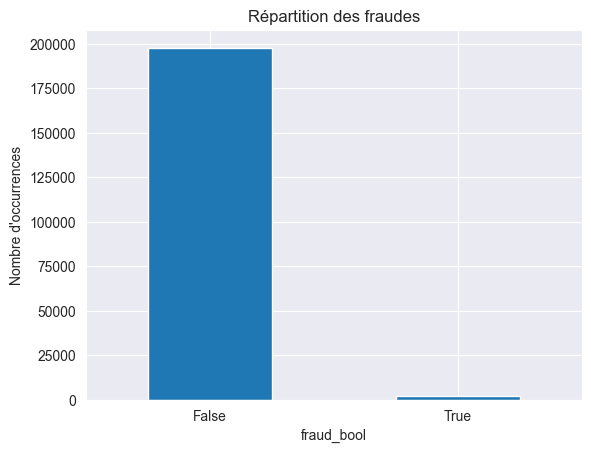

In [4]:
fraud_counts = df['fraud_bool'].value_counts()

fraud_counts.plot(kind='bar')
plt.title("Répartition des fraudes")
plt.xlabel("fraud_bool")
plt.ylabel("Nombre d'occurrences")
plt.xticks(ticks=[0, 1], labels=['False', 'True'], rotation=0)
plt.show()

Réponse ici:
On voit un très fort déséquilibre entre les deux classes. Très peu de transactions sont des fraudes.

4. Avant toute chose, nous allons séparer les données en trois ensembles : d'apprentissage (train_data), de validation (val_data) et de test (test_data). Nous ferons une **séparation stratifiée** car les données sont fortement débalancées entre fraudes ou non. Utiliser la fonction *train_test_split* de la librairie [scikit-learn train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) pour faire cette séparation (On séparera les données en ensemble de 70%, 15%, 15%).

In [5]:
X = df.drop(columns=["fraud_bool"])
y = df["fraud_bool"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,  # Permet de faire une séparation stratifiée
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,  # Permet de faire une séparation stratifiée
    random_state=42
)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

train_fraud_ratio = y_train.mean() * 100
val_fraud_ratio = y_val.mean() * 100
test_fraud_ratio = y_test.mean() * 100

print(
    f"Pourcentage de fraudes dans le jeu d'entraînement : {train_fraud_ratio:.2f}%")
print(
    f"Pourcentage de fraudes dans le jeu de validation  : {val_fraud_ratio:.2f}%")
print(
    f"Pourcentage de fraudes dans le jeu de test        : {test_fraud_ratio:.2f}%")

Train: (140000, 30), (140000,)
Validation: (30000, 30), (30000,)
Test: (30000, 30), (30000,)
Pourcentage de fraudes dans le jeu d'entraînement : 1.05%
Pourcentage de fraudes dans le jeu de validation  : 1.06%
Pourcentage de fraudes dans le jeu de test        : 1.05%


5. S'assurer de l'intégrité des données en recherchant de potentielles valeurs manquantes. Afficher les catégories pour lesquelle il manque des données (celles-ci sont annotées par -1 dans le dataset), la quantitée de données manquantes par catégorie et le ratio de données manquantes par catégorie sur le total de données.

**Important**: Avant chaque étape de processing de vos données, il est important de toujours se rappeler que les données de validation et de test sont considérées "inconnues" préalablement à leur utilisation, et doivent représenter la distribution réelle des données. Il faut donc bien réfléchir quoi faire avec ces données pour ne pas biaiser vos résultats, voir les rendre faux!

In [6]:
def detect_missing_values(X: pd.DataFrame):
    """
    Détecte les colonnes contenant des valeurs manquantes annotées par -1,
    retourne un DataFrame avec le nombre et le ratio de ces valeurs.
    """
    missing_info = []

    for col in X.columns:
        if (X[
                col] == -1).any():  # X[col] == - 1 vecteur de booléens - calcul élément par élément
            nb_missing = (X[col] == -1).sum()
            ratio_missing = nb_missing / len(X)
            missing_info.append((col, nb_missing, ratio_missing))

    # Résultat sous forme de DataFrame
    return pd.DataFrame(missing_info, columns=["Catégorie", "Nb manquants",
                                               "Ratio manquant"]).sort_values(
        by="Ratio manquant", ascending=False)


# Exécution uniquement sur le jeu d'entraînement
# On calcule les stats sur cet ensemble puis on appliquera le traitement aux autres ensembles
missing_df = detect_missing_values(X_train)

# Affichage
print("Colonnes avec des valeurs manquantes (-1) dans le jeu d'entraînement :")
print(missing_df)

Colonnes avec des valeurs manquantes (-1) dans le jeu d'entraînement :
                      Catégorie  Nb manquants  Ratio manquant
0     prev_address_months_count         99874        0.713386
3             bank_months_count         35459        0.253279
1  current_address_months_count           597        0.004264
4     session_length_in_minutes           282        0.002014
2             credit_risk_score            68        0.000486
5     device_distinct_emails_8w            37        0.000264


In [7]:
missing_df_val = detect_missing_values(X_val)
print("Colonnes avec des valeurs manquantes (-1) dans le jeu de validation :")
print(missing_df_val)

Colonnes avec des valeurs manquantes (-1) dans le jeu de validation :
                      Catégorie  Nb manquants  Ratio manquant
0     prev_address_months_count         21384        0.712800
3             bank_months_count          7703        0.256767
1  current_address_months_count           120        0.004000
4     session_length_in_minutes            63        0.002100
2             credit_risk_score            20        0.000667
5     device_distinct_emails_8w             8        0.000267


In [8]:
missing_df_test = detect_missing_values(X_test)
print("Colonnes avec des valeurs manquantes (-1) dans le jeu de test :")
print(missing_df_test)

Colonnes avec des valeurs manquantes (-1) dans le jeu de test :
                      Catégorie  Nb manquants  Ratio manquant
0     prev_address_months_count         21362        0.712067
3             bank_months_count          7587        0.252900
1  current_address_months_count           126        0.004200
4     session_length_in_minutes            59        0.001967
2             credit_risk_score            14        0.000467
5     device_distinct_emails_8w            10        0.000333


 Nous n'allons pas utiliser les informations statistiques des jeu de validation et de test. Les deux dernières case permette de vérifier que les colonnes concernées par les données manquantes sont toutes repérer. Cela permettra de simplifier le code en n'ayant pas besoin de remplacer dans les autres colonnes.



6. Remplacer les valeurs manquantes par la valeur médiane de la colonne correspondante. Bien réfléchir à ce que cela implique pour les données de validation et de test.

Observation de la répartition des valeurs dans les colonnes ayant des valeurs manquantes

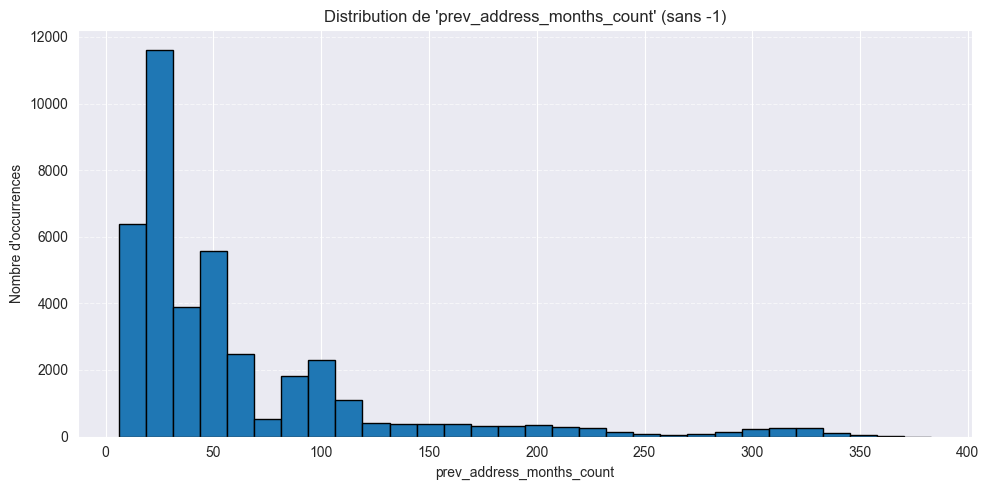

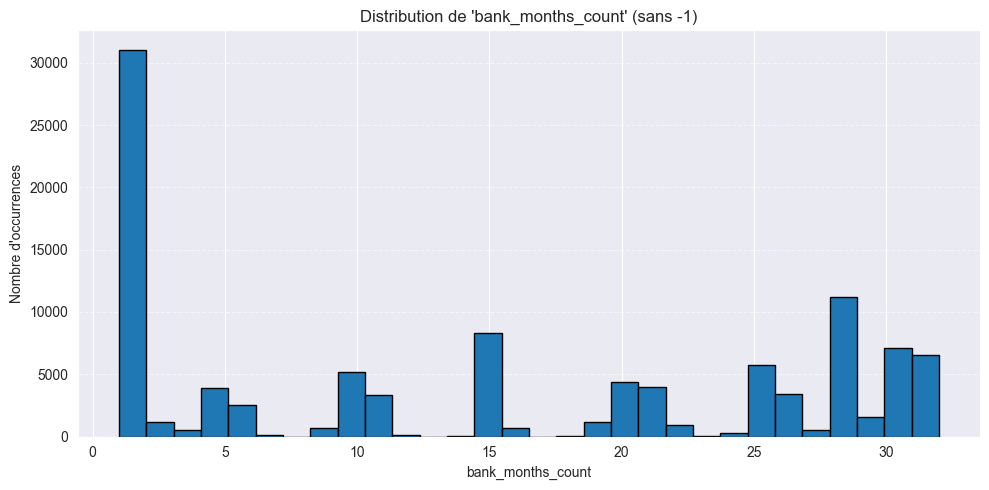

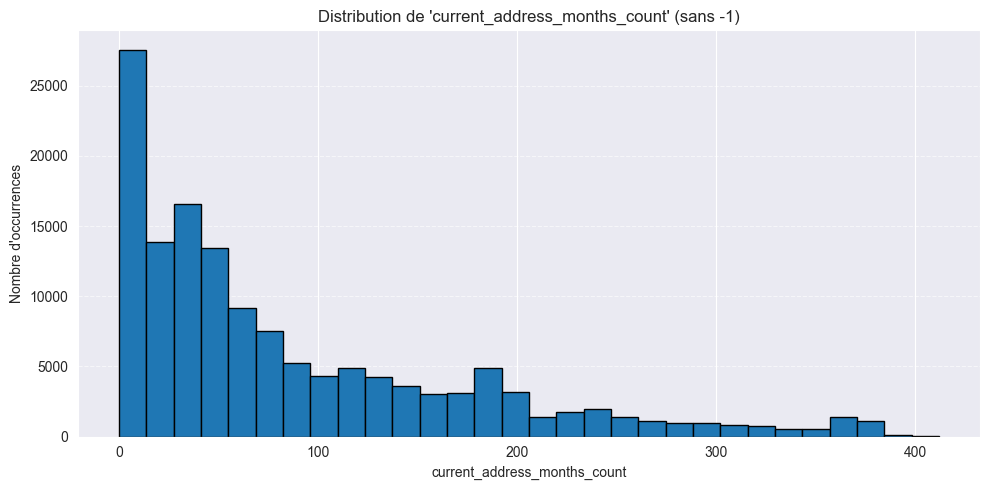

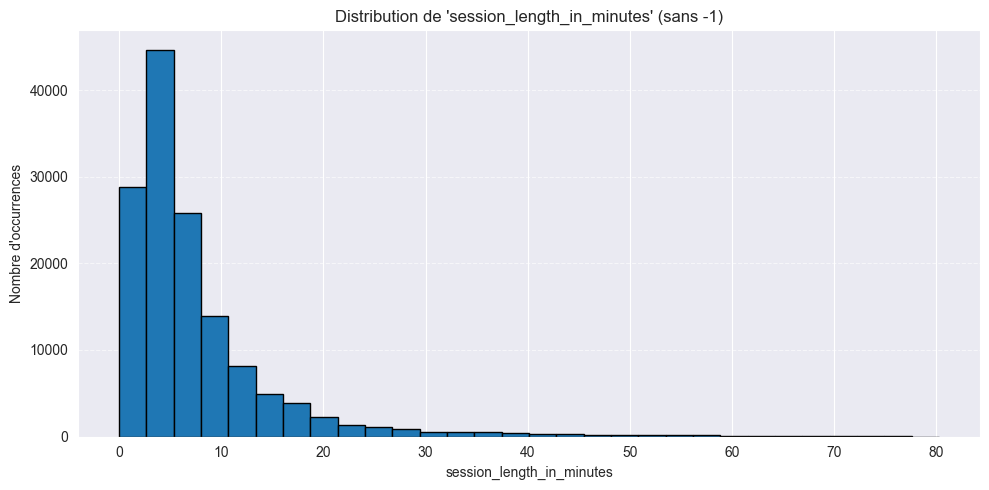

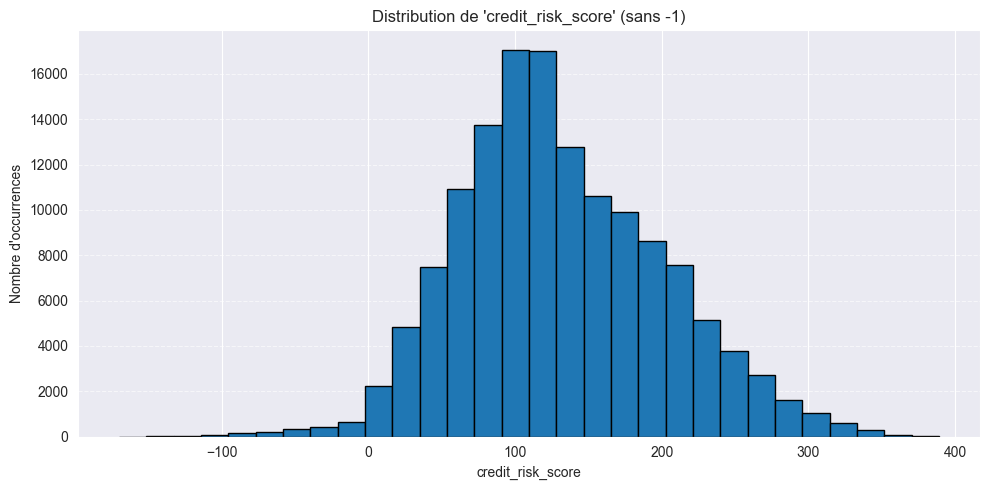

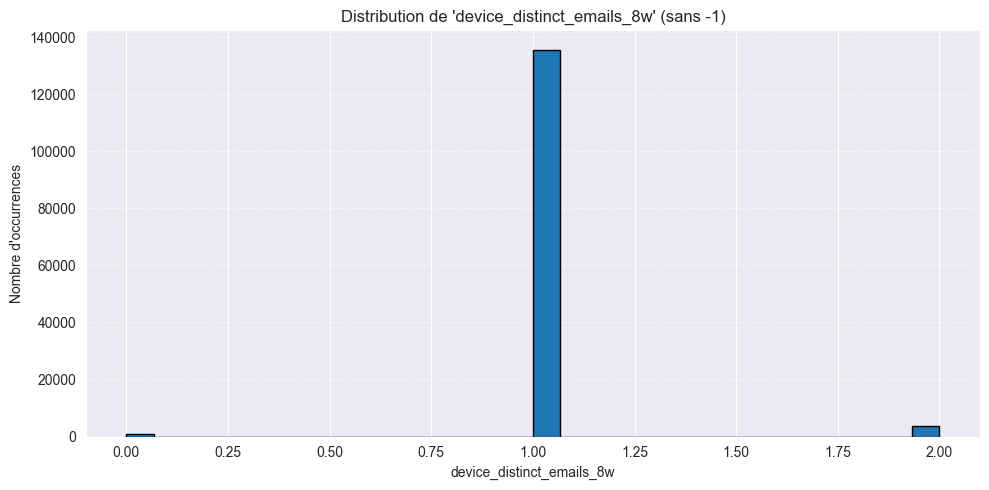

In [9]:
columns_with_missing = [
    "prev_address_months_count",
    "bank_months_count",
    "current_address_months_count",
    "session_length_in_minutes",
    "credit_risk_score",
    "device_distinct_emails_8w"
]

# Affichage des histogrammes pour chaque colonne
for col in columns_with_missing:
    data = X_train[col]
    data_filtered = data[data != -1]

    plt.figure(figsize=(10, 5))
    plt.hist(data_filtered, bins=30, edgecolor='black')
    plt.title(f"Distribution de '{col}' (sans -1)")
    plt.xlabel(col)
    plt.ylabel("Nombre d'occurrences")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

Fonction utilitaires pour remplacer les valeurs abérrantes et afficher les résultats

In [12]:

def extract_sampling_distributions(X, columns):
    """
    Extrait les distributions des colonnes contenant des -1,
    pour ensuite les réutiliser sur val/test sans recalcul.
    """
    distributions = {}
    for col in columns:
        values = X[col][X[col] != -1]
        distributions[col] = values.values  # np.array
    return distributions

def plot_sampling_distribution(reference, sampled, col):
    """
    Affiche un histogramme comparant la distribution d'origine
    avec celle des valeurs imputées.
    """
    if not pd.api.types.is_numeric_dtype(reference):
        original_counts = pd.Series(reference).value_counts().sort_index()
        sampled_counts = pd.Series(sampled).value_counts().sort_index()
        df = pd.DataFrame({
            "originales": original_counts,
            "imputées": sampled_counts
        }).fillna(0)
        df.plot(kind="bar", figsize=(12, 6), alpha=0.75)
        plt.title(f"Distribution d'imputation pour '{col}' (catégorielle)")
        plt.xlabel(col)
        plt.ylabel("Nombre d'occurrences")
    else:
        plt.figure(figsize=(12, 6))
        plt.hist(reference, bins=30, alpha=0.6, label="Valeurs originales (X_train)", edgecolor='black')
        plt.hist(sampled, bins=30, alpha=0.6, label="Valeurs imputées", edgecolor='black')
        plt.title(f"Distribution d'imputation pour '{col}'")
        plt.xlabel(col)
        plt.ylabel("Nombre d'occurrences")
        plt.legend()

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def apply_sampling_imputation(X, column_name, distribution_values, show_plot=False, reference_distribution=None):
    """
    Retourne une copie de X avec les -1 imputés dans `column_name`.
    """
    X_copy = X.copy()
    mask_missing = (X_copy[column_name] == -1)
    n_missing = mask_missing.sum()

    if n_missing > 0:
        sampled = np.random.choice(distribution_values, size=n_missing, replace=True)
        X_copy.loc[mask_missing, column_name] = sampled

        if show_plot and reference_distribution is not None:
            plot_sampling_distribution(reference_distribution, sampled, column_name)

    return X_copy


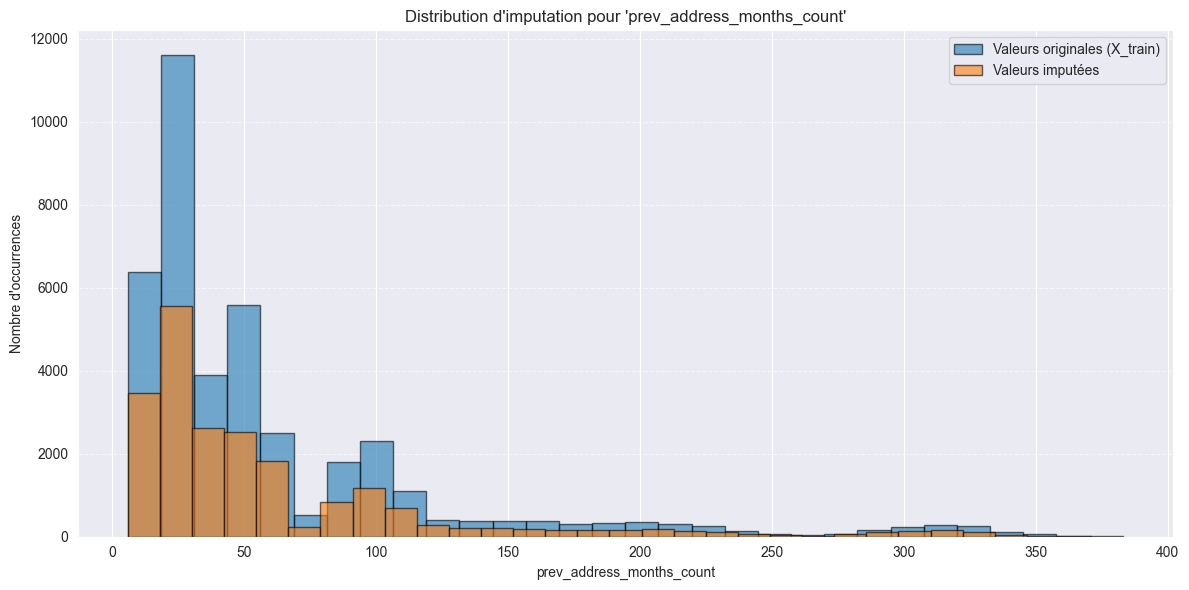

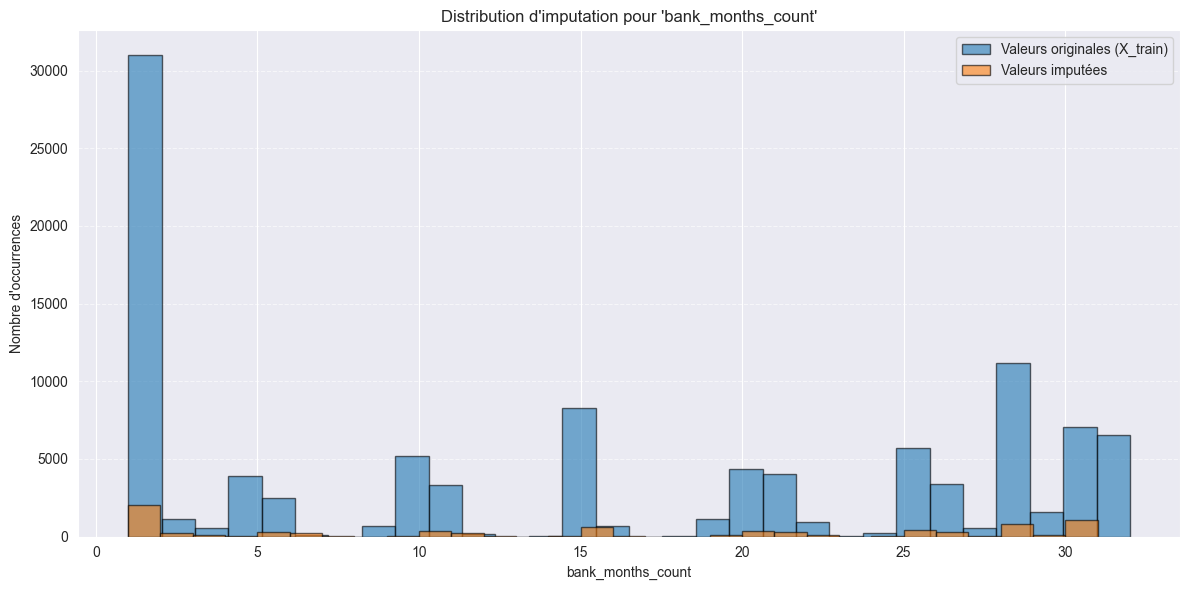

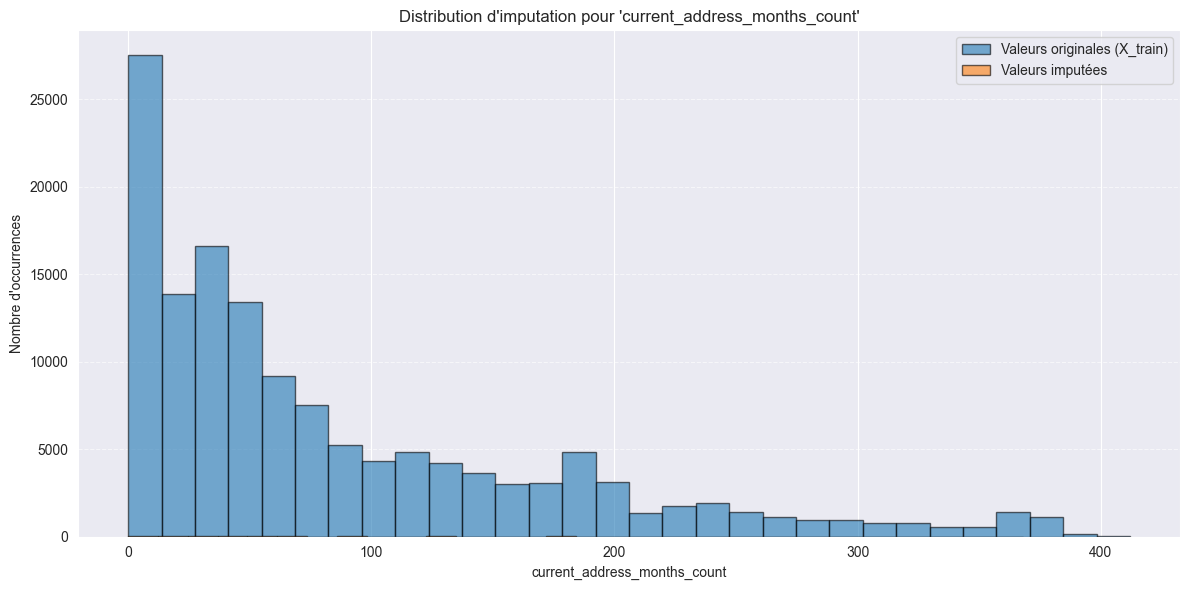

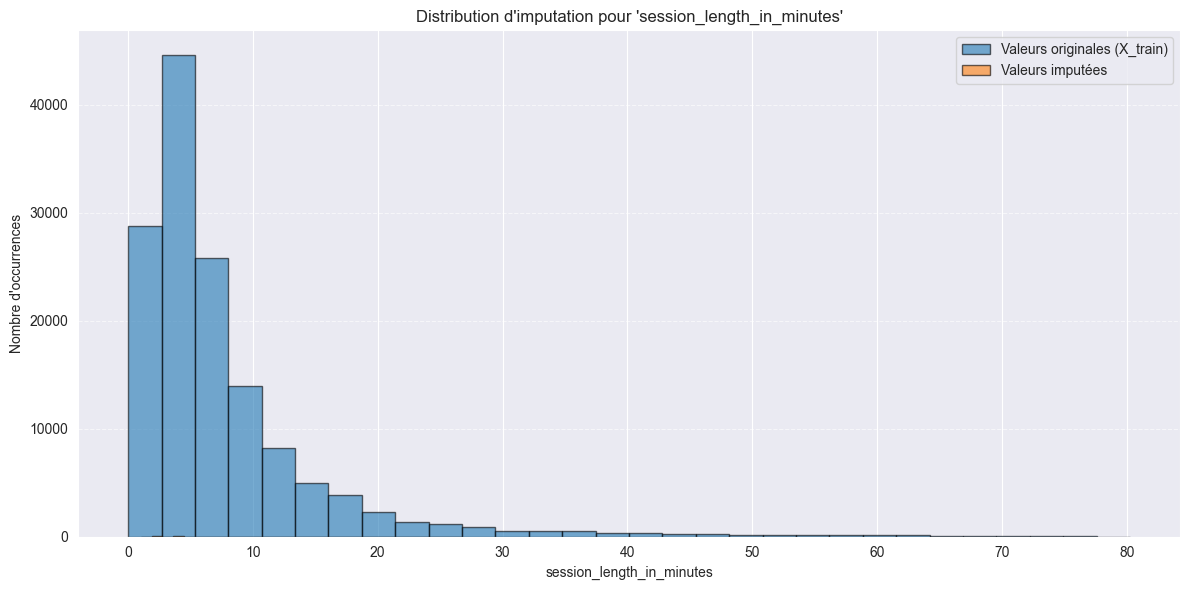

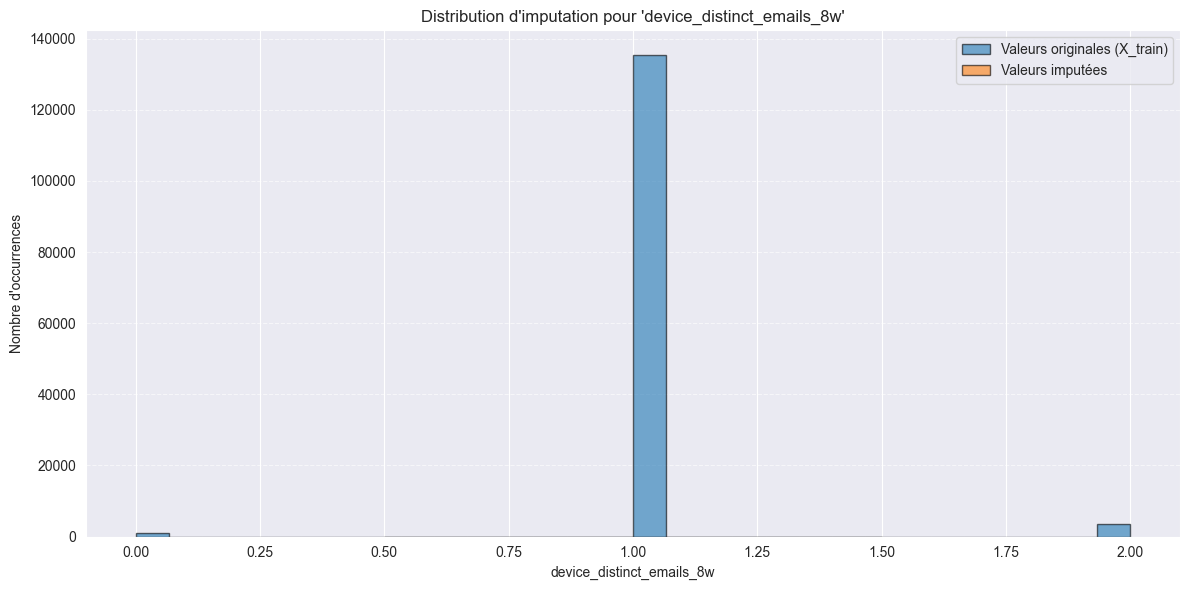

In [13]:

# Liste des colonnes à imputer
columns_with_missing = [
    "prev_address_months_count",
    "bank_months_count",
    "current_address_months_count",
    "session_length_in_minutes",
    "device_distinct_emails_8w"
]

# Extraire les distributions depuis X_train (référence)
sampling_distributions = extract_sampling_distributions(X_train, columns_with_missing)

# Créer des copies imputées
X_train_imputed = X_train.copy()
X_val_imputed = X_val.copy()
X_test_imputed = X_test.copy()

for col in columns_with_missing:
    X_train_imputed = apply_sampling_imputation(
        X_train_imputed, col,
        sampling_distributions[col],
        show_plot=False  # facultatif ici
    )
    X_val_imputed = apply_sampling_imputation(
        X_val_imputed, col,
        sampling_distributions[col],
        show_plot=True,
        reference_distribution=sampling_distributions[col]
    )
    X_test_imputed = apply_sampling_imputation(
        X_test_imputed, col,
        sampling_distributions[col],
        show_plot=False
    )


7. On notera que chacune des différentes catégories (colonnes) peut-être définie dans l'une des trois catégories suivantes:
- Catégorie 1: Données numériques (ex. montant de la transaction, etc.)
- Catégorie 2: Données catégorielles (ex. type de transaction, etc.)
- Catégorie 3: Données de type booléen (ex. transaction frauduleuse ou non, etc.)

Afficher une liste pour chaque catégorie de données (numérique *numeric_columns*, catégorielle *categorical_columns*, ou booléen *boolean_columns*), contenant le nom des colonnes (key) de données qui appartiennent à cette catégorie.

In [14]:
df = X_train  # ou autre nom

# Colonnes booléennes (vraies ou 0/1)
bool_like = [col for col in df.columns
             if pd.api.types.is_numeric_dtype(df[col])
             and set(df[col].dropna().unique()).issubset({0, 1})]

df_bool = df[bool_like]
print("Colonnes booléennes ou binaires :")
print(df_bool.head(), end="\n\n")

# Colonnes numériques (hors bool-like)
numeric_columns = [
    col for col in df.select_dtypes(include=["number"]).columns
    if col not in bool_like
]

df_numeric = df[numeric_columns]
print("Colonnes numériques :")
print(df_numeric.head(), end="\n\n")

# Colonnes catégorielles (objet ou catégorie)
categorical_columns = df.select_dtypes(include=["object", "category"]).columns.tolist()
df_categorical = df[categorical_columns]
print("Colonnes catégorielles :")
print(df_categorical.head(), end="\n\n")

Colonnes booléennes ou binaires :
        email_is_free  phone_home_valid  phone_mobile_valid  has_other_cards  \
90545               1                 0                   1                0   
120094              0                 1                   1                1   
74684               0                 0                   1                0   
53570               0                 0                   1                0   
40924               0                 0                   1                1   

        foreign_request  keep_alive_session  
90545                 0                   1  
120094                0                   0  
74684                 0                   1  
53570                 0                   0  
40924                 0                   0  

Colonnes numériques :
        income  name_email_similarity  prev_address_months_count  \
90545      0.9               0.452207                         28   
120094     0.9               0.282920             

8. Pour les données de chaque catégorie numérique, afficher la distribution de données superposée entre les transations frauduleuses et celles n'en étant pas (pour les données d'entraînement). Vous pouvez de nouveau utiliser la librairie [matplotlib](https://matplotlib.org/) ou [seaborn](https://seaborn.pydata.org/) pour afficher les distributions de données.  

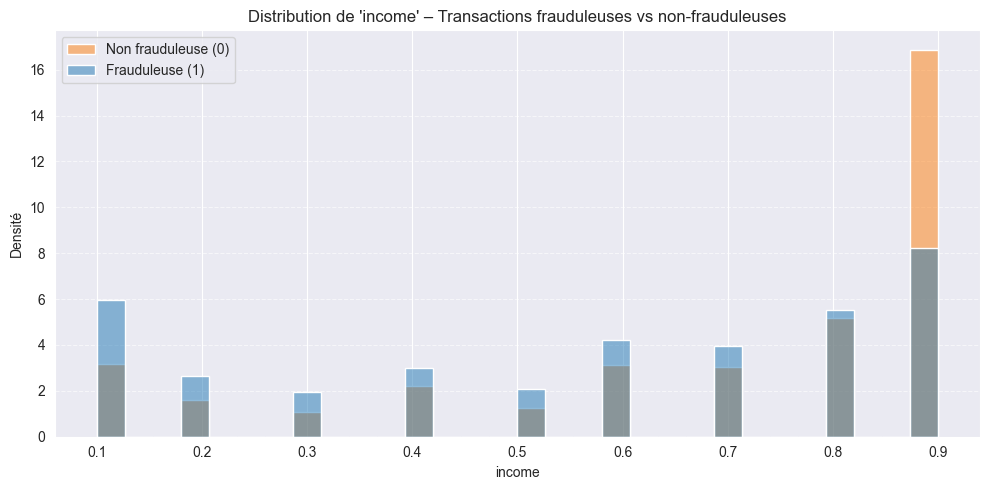

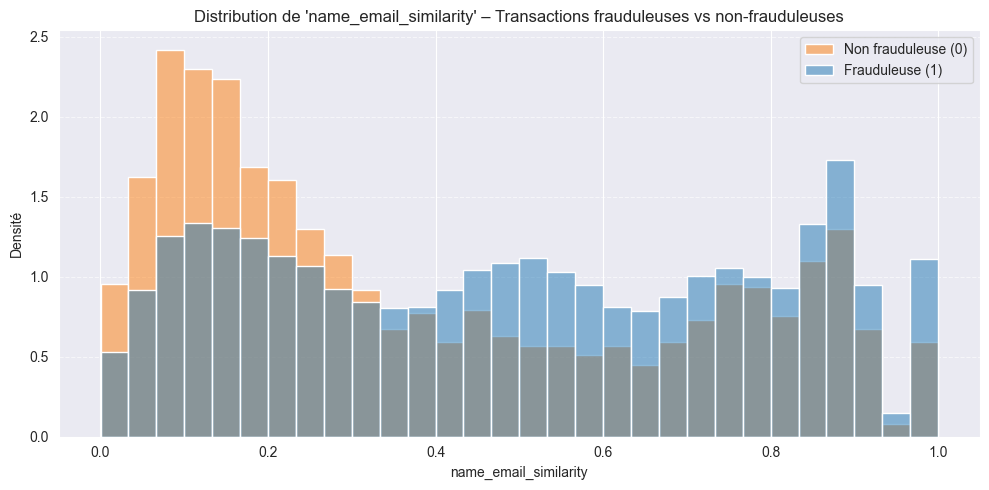

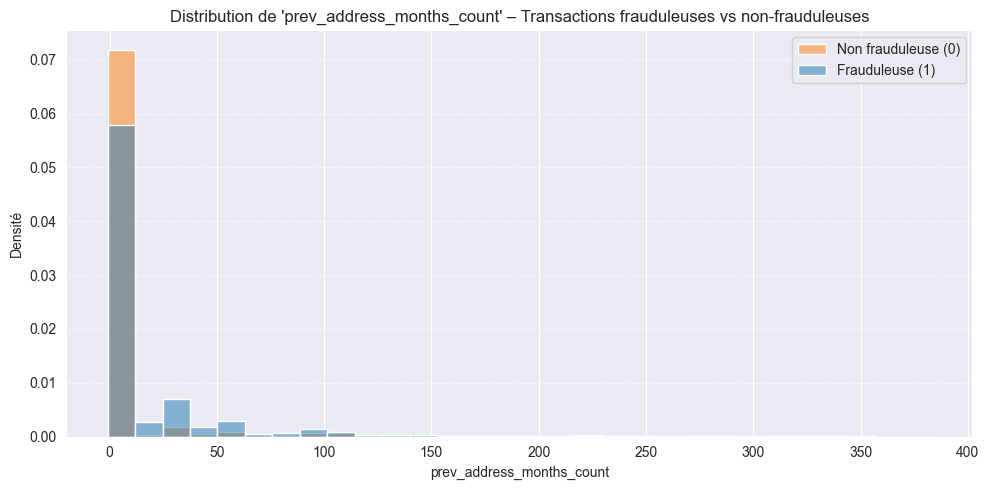

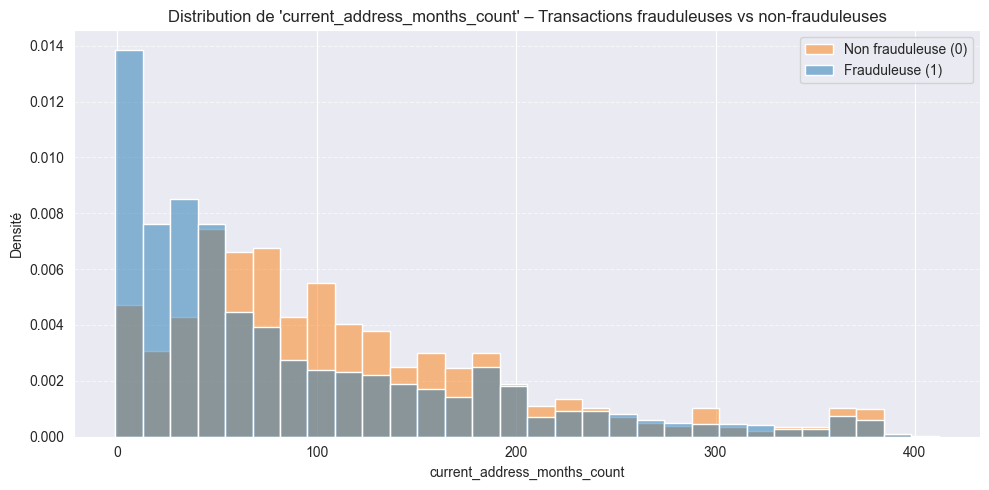

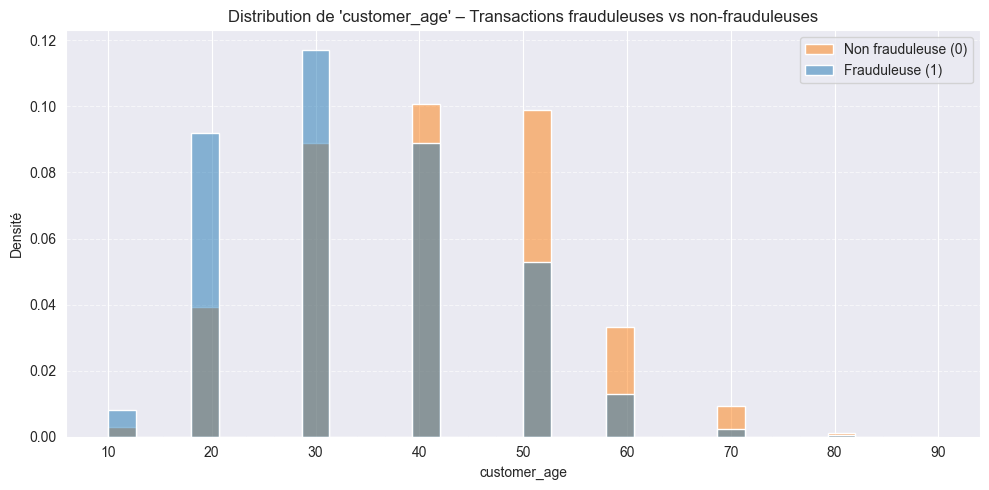

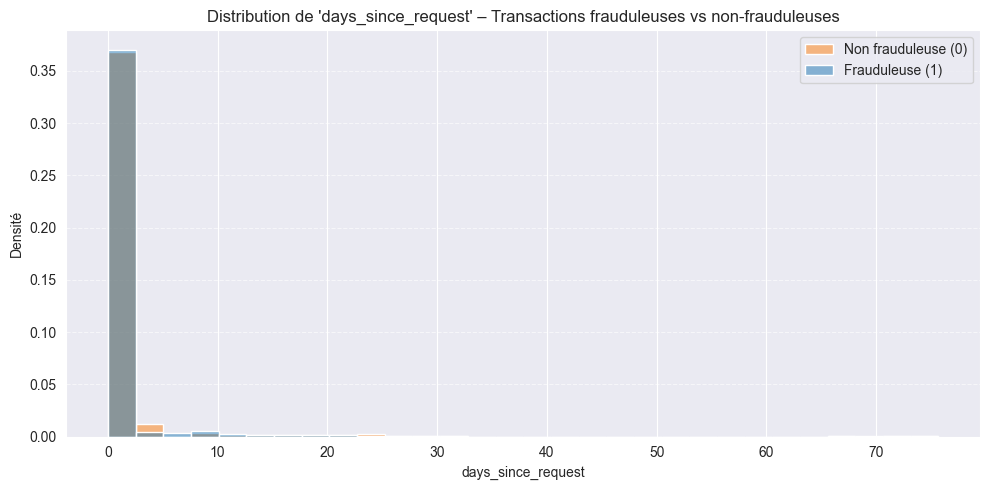

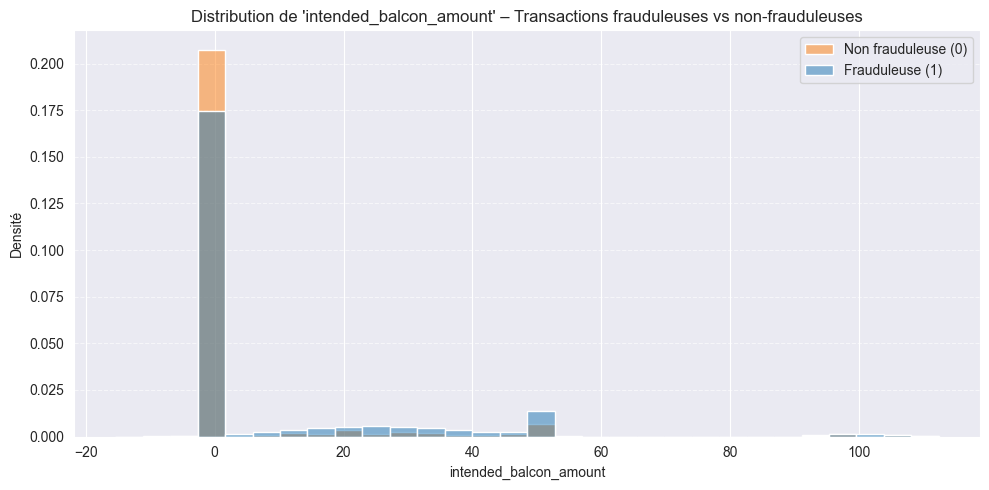

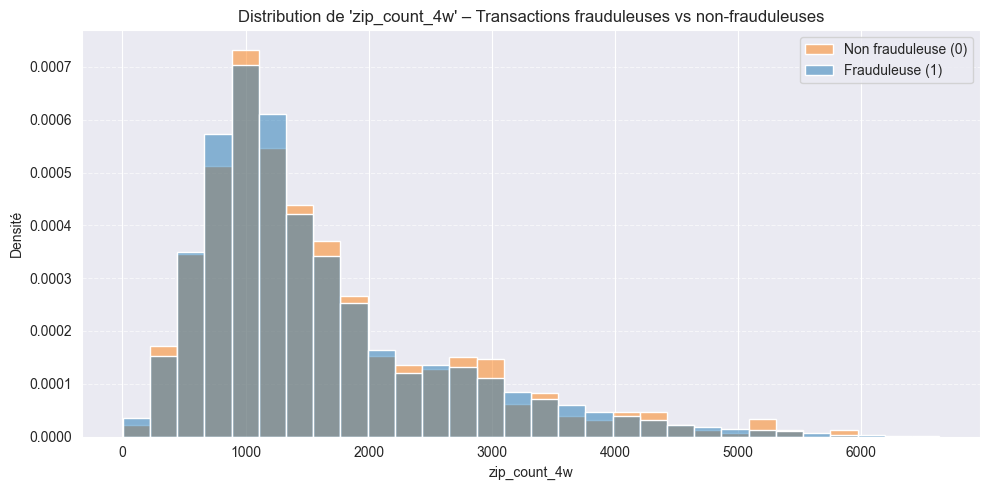

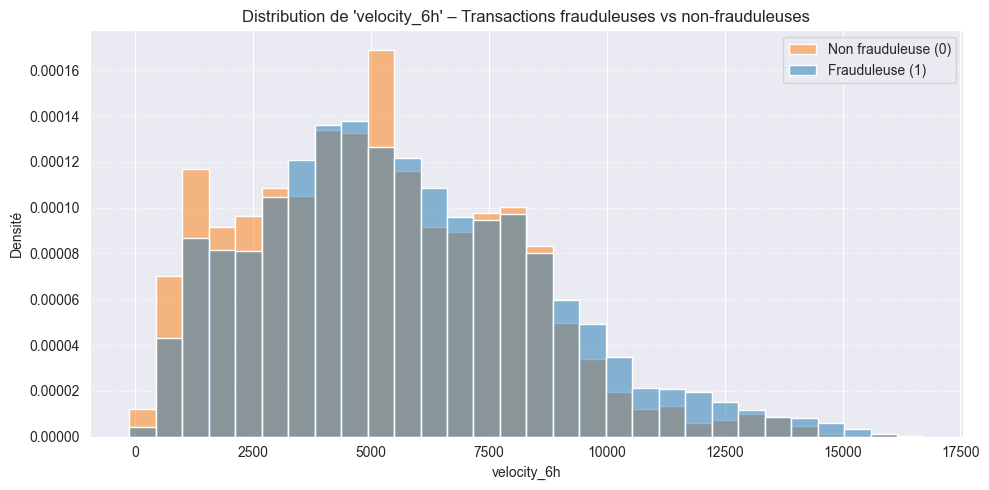

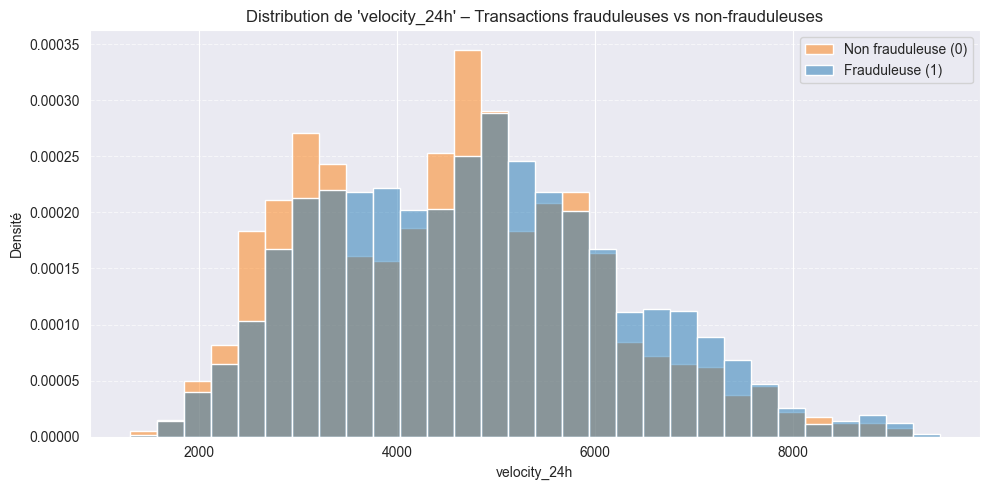

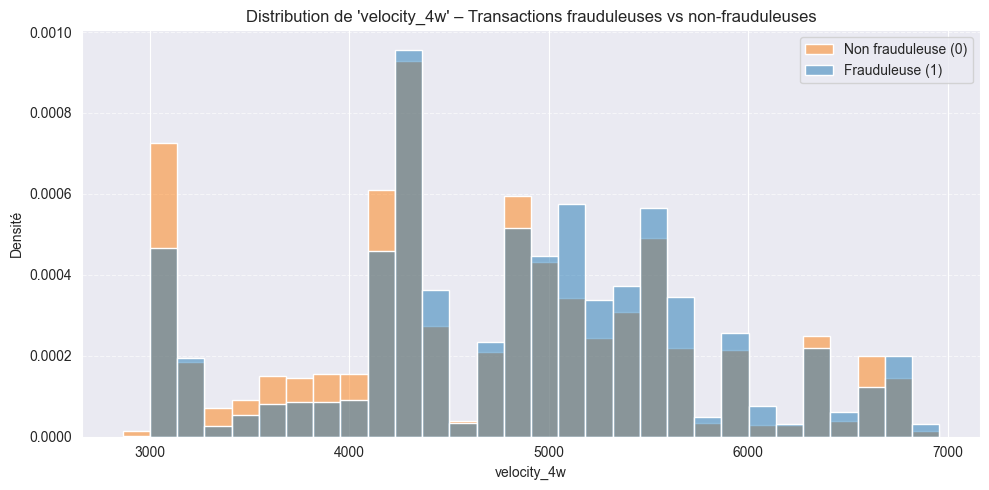

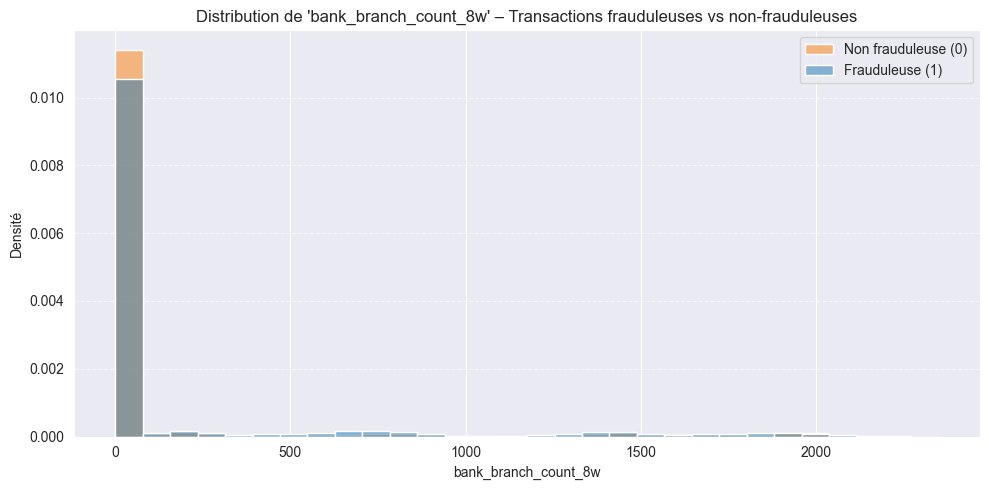

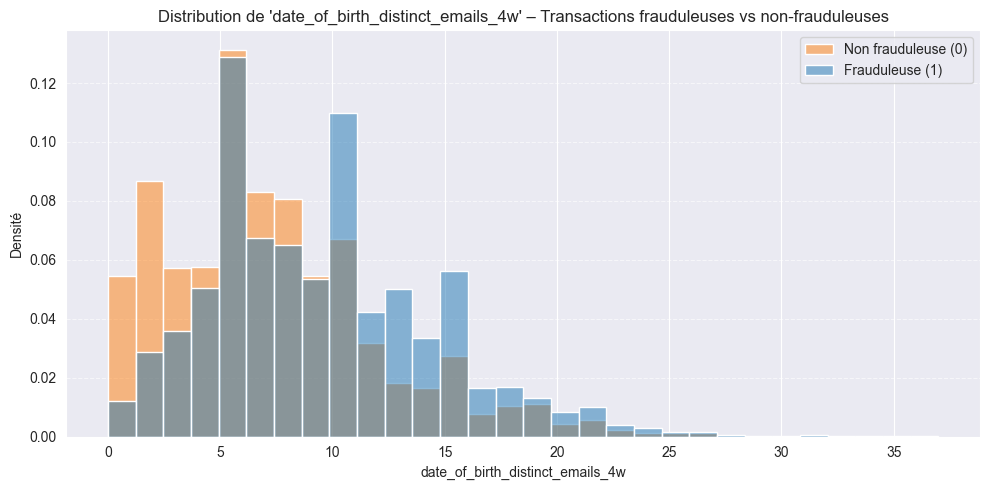

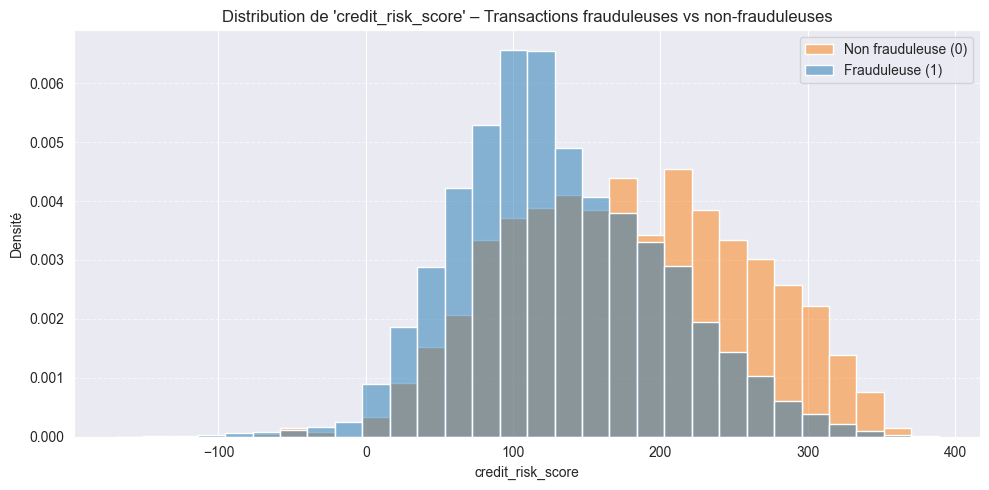

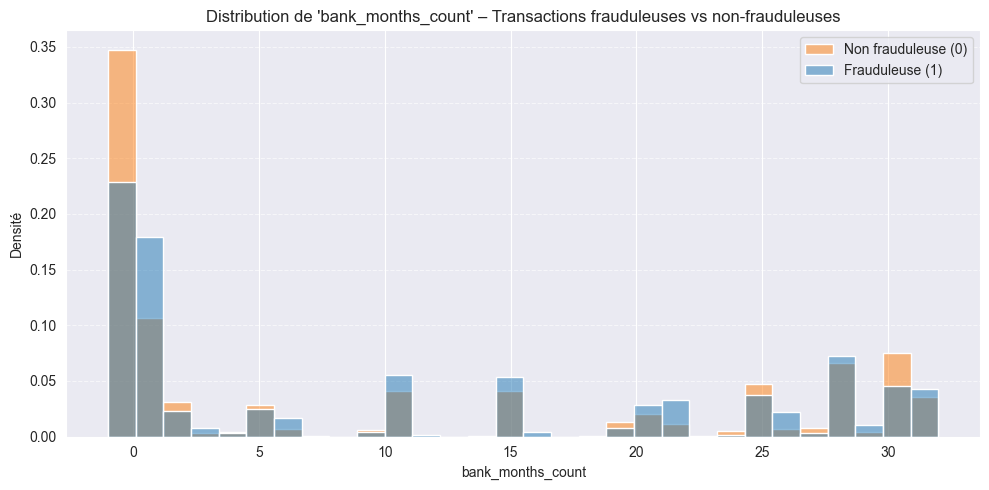

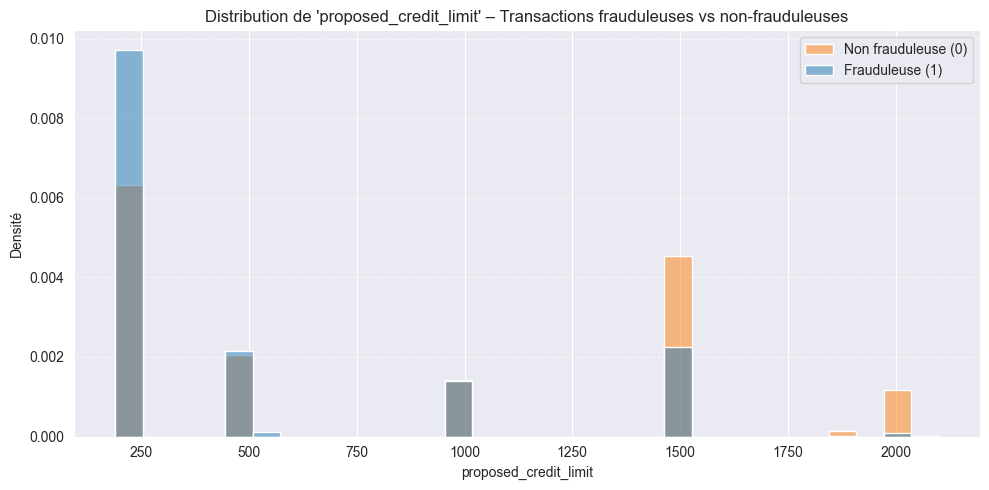

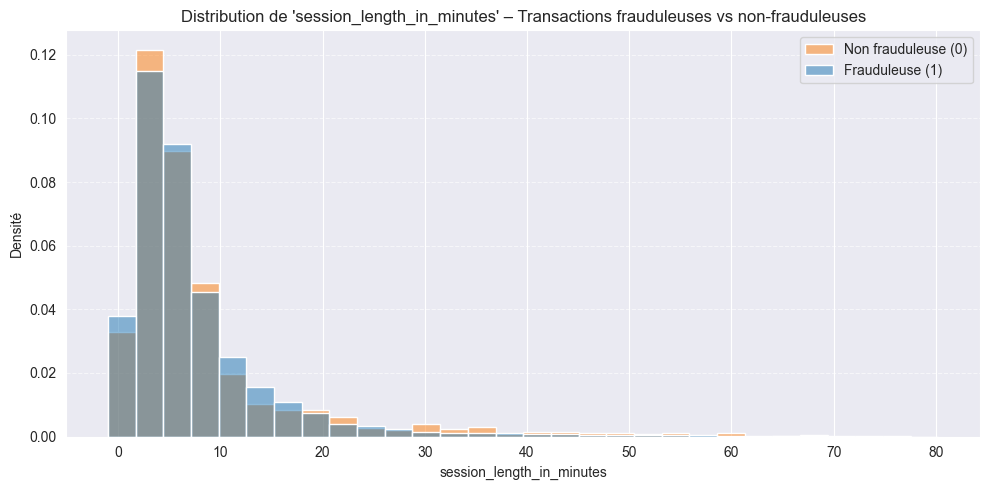

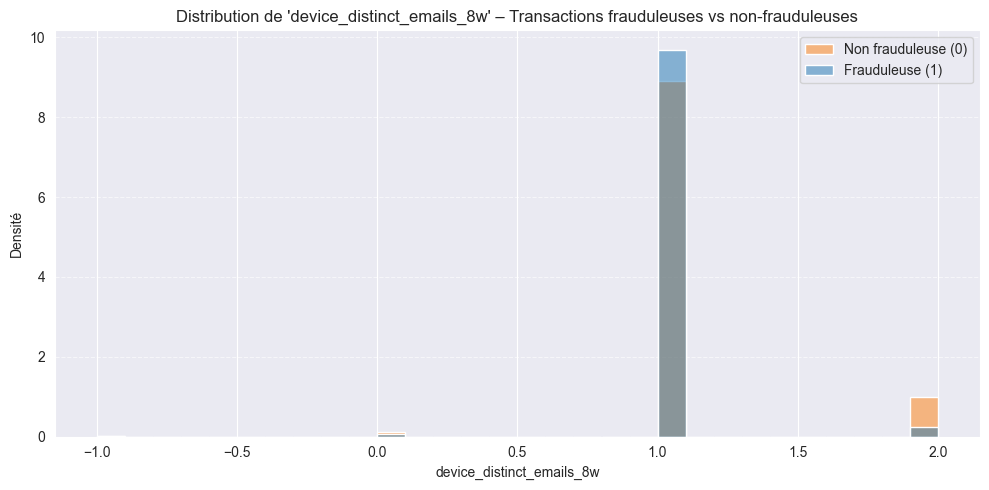

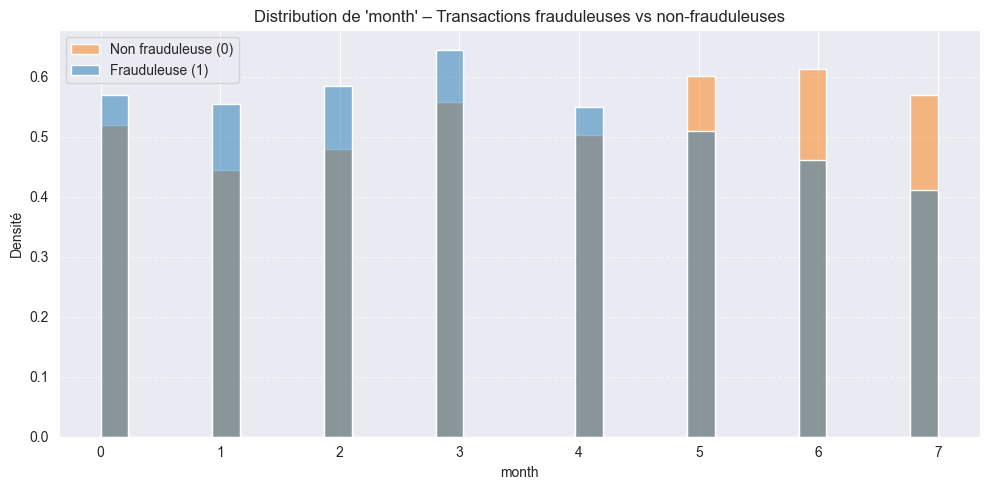

In [15]:
# On suppose que X_train contient les features et y_train les étiquettes
Xy_train = X_train.copy()
Xy_train["fraud_bool"] = y_train  # on ajoute la cible dans le DataFrame

# Liste des colonnes numériques (hors bool)
numeric_columns = [
    col for col in X_train.select_dtypes(include=["number"]).columns
    if set(X_train[col].dropna().unique()).difference({0, 1})
]

# Pour chaque colonne numérique, afficher la distribution superposée
for col in numeric_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=Xy_train, x=col, hue="fraud_bool", bins=30, stat="density", common_norm=False)
    plt.title(f"Distribution de '{col}' – Transactions frauduleuses vs non-frauduleuses")
    plt.xlabel(col)
    plt.ylabel("Densité")
    plt.legend(labels=["Non frauduleuse (0)", "Frauduleuse (1)"])
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

9. Considérant les distributions de données d'entrainement, donner une brève opinion / intuition sur la possibilité de classifier les transactions frauduleuses et celles n'en étant pas.

Les répartitions les plus intéressantes pour discriminer les deux catégories sont celle où les données sont fortement séparées. Visuellement, ce sont les histogramme ou des zones sont majoritairement Non frauduleuses ou majoritairement frauduleuse.

On peut rapidement remarquer que les catégories suivantes seront certainement pertinentes pour discriminer les deux catégories :
income
name email similarity
current address mounths count
customer age
credit risk score
month

# Partie 2 - Préparation des données et classification par template matching

La partie 1 aura permis de faire une première analyse des données, et un premier prétraitement des données en s'attaquant aux données manquantes. Nous allons maintenant approfondir le traitement des données pour préparer la classification, puis appliquer la méthode appelée "template matching".

Un des points essentiels au bon fonctionnement des algorithmes d'apprentissage machine est, pour une grande majorité d'agorithmes, la normalization (scaling) des données. Cependant, le scaling des données peut-être fait de différentes manières, et peut aussi avoir un impact négatif sur les résultats de certains algorithmes si celle-ci n'est pas fait intelligemment. Vous êtes invités à survoler le papier suivant  - [paper link](https://www.sciencedirect.com/science/article/pii/S1568494622009735?fr=RR-2&ref=pdf_download&rr=93e5d0c1ecd57151) - pour motiver vos réponses aux questions à venir. N'hésitez pas à approfondir sa lecture au besoin.  

###  <font color=blue> Questions: </font>

1. Avant toute normalization de vos données, justifier pourquoi on ne pourra pas calculer la moyenne, l'écart-type, ou toute autre mesure statistique sur les bases val_data et test_data dans l'optique de leur normalization.

Réponse ici:
Nous ne sommes pas sensé avoir d'information sur les données de validation et de test afin de garantir la précision réelle du modèle. Si l'on utilise des métriques issues de ces set de données on va contaminer notre modèle puisqu'il aura été crée en connaissant des informations sur les données de tests.

2. Commencer par choisir deux méthodes de normalisation différentes (ex. MinMaxScaler, StandardScaler, RobustScaler, etc.), en choisissant une normalization sensible aux outliers et une qui ne l'est pas. Appliquer chacune d'elles sur les données d'apprentissage. Normaliser aussi les données de validation et de test, tout en prenant en compte votre réponse à la question précédente.

Remarque: On nommera les nouvelles bases de train validation et test de la façons suivante: {data}_{scaler}. ex: train_data_minmax, val_data_minmax, test_data_minmax, train_data_standard, val_data_standard, test_data_standard.

In [16]:
# 1. Fusionner les X imputés avec y
train_full = X_train_imputed.copy()
train_full["fraud_bool"] = y_train

val_full = X_val_imputed.copy()
val_full["fraud_bool"] = y_val

test_full = X_test_imputed.copy()
test_full["fraud_bool"] = y_test

# 2. Colonnes numériques (hors booléennes)
numeric_columns = [
    col for col in X_train_imputed.select_dtypes(include=["number"]).columns
    if set(X_train_imputed[col].dropna().unique()).difference({0, 1})
]

# 3. Normalisation 1 : MinMaxScaler - sensible aux outliers
minmax_scaler = MinMaxScaler()
train_data_minmax = train_full.copy()
val_data_minmax = val_full.copy()
test_data_minmax = test_full.copy()

train_data_minmax[numeric_columns] = minmax_scaler.fit_transform(train_full[numeric_columns])
val_data_minmax[numeric_columns] = minmax_scaler.transform(val_full[numeric_columns])
test_data_minmax[numeric_columns] = minmax_scaler.transform(test_full[numeric_columns])

# 4. Normalisation 2 : RobustScaler - robuste aux outliers
robust_scaler = RobustScaler()
train_data_robust = train_full.copy()
val_data_robust = val_full.copy()
test_data_robust = test_full.copy()

train_data_robust[numeric_columns] = robust_scaler.fit_transform(train_full[numeric_columns])
val_data_robust[numeric_columns] = robust_scaler.transform(val_full[numeric_columns])
test_data_robust[numeric_columns] = robust_scaler.transform(test_full[numeric_columns])

3. Nous allons maintenant classifier les opérations frauduleuses ou non en suivant une approche de *template matching* (plus proche prototype).

3a. Commencer par définir une fonction qui retourne un template pour chaque classe (fraude ou non). Dans le cas présent, chaque template est défini comme étant la moyenne des valeurs par colonne.

Plusieurs considérations sont importantes:

-> On pourra prendre la moyenne des données numériques et binaires (boolean)

-> Pour les données catégorielles, on pourra utiliser *pd.get_dummies* dans un premier temps (cette fonction créer des colonnes binaires pour chaque catégorie de la colonne - One-hot encoding). Ensuite, obtenir la moyenne de chaque colonne binaire.



In [23]:
def compute_class_templates(X, y):
    """
    Calcule un template moyen pour chaque classe (0 et 1).
    Utilise les colonnes numériques, booléennes, et les catégorielles encodées (one-hot).
    """
    # Fusionner les features et la cible
    df = X.copy()
    df["fraud_bool"] = y

    # Séparation des types
    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
    bool_cols = [col for col in numeric_cols if set(df[col].dropna().unique()).issubset({0, 1})]
    numeric_cols = [col for col in numeric_cols if col not in bool_cols and col != "fraud_bool"]
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

    # One-hot encoding des colonnes catégorielles
    df_encoded = pd.get_dummies(df[categorical_cols])

    # Regroupement des données finales à utiliser pour les templates
    full_data = pd.concat([
        df[numeric_cols],
        df[bool_cols],
        df_encoded
    ], axis=1)

    # Ajout de la colonne cible pour groupby
    full_data["fraud_bool"] = y.values

    # Moyenne par classe → c’est notre template
    templates = full_data.groupby("fraud_bool").mean()

    return templates

templates = compute_class_templates(X_train, y_train)
template_0 = templates.loc[0]  # Non frauduleux
template_1 = templates.loc[1]  # Frauduleux

print(f"Template non frauduleux \n {template_0} \n" + "-" * 50 )
print(f"Template frauduleux \n {template_1}")

Template non frauduleux 
 income                                 0.561215
name_email_similarity                  0.495369
prev_address_months_count             16.828600
current_address_months_count          86.230624
customer_age                          33.662975
days_since_request                     1.041853
intended_balcon_amount                 8.679564
zip_count_4w                        1572.865511
velocity_6h                         5682.194481
velocity_24h                        4781.103721
velocity_4w                         4861.288168
bank_branch_count_8w                 184.664636
date_of_birth_distinct_emails_4w       9.529843
credit_risk_score                    130.294729
bank_months_count                     10.836007
proposed_credit_limit                511.092374
session_length_in_minutes              7.531822
device_distinct_emails_8w              1.017730
month                                  3.278630
email_is_free                          0.529713
phone_home_val

3b. En utilisant ces templates, proposer une fonction permettant de classifier les données d'un ensemble (validation/test) étant donné les templates produits issus de la fonction précédente. La fonction devra retourner un numpy array pour les données prédites et les données réelles.

In [18]:
def predict_with_templates(X, y_true, templates, categorical_cols=None):
    """
    Classifie les lignes de X en comparant leur distance aux templates.

    Args:
        X (pd.DataFrame): données d'entrée (val/test)
        y_true (pd.Series or np.ndarray): vraies étiquettes (fraud_bool)
        templates (pd.DataFrame): un DataFrame contenant les templates (moyennes par classe)
        categorical_cols (list): noms des colonnes catégorielles, si besoin de one-hot encoding

    Returns:
        y_pred (np.ndarray): prédictions
        y_true (np.ndarray): vraies étiquettes
    """

    X_copy = X.copy()

    # Détecter les types si non spécifié
    if categorical_cols is None:
        categorical_cols = X_copy.select_dtypes(include=["object", "category"]).columns.tolist()

    numeric_cols = X_copy.select_dtypes(include=["number"]).columns.tolist()
    bool_cols = [col for col in numeric_cols if set(X_copy[col].dropna().unique()).issubset({0, 1})]
    numeric_cols = [col for col in numeric_cols if col not in bool_cols]

    # One-hot encoding des colonnes catégorielles
    X_encoded = pd.get_dummies(X_copy[categorical_cols])

    # Alignement avec les templates (colonnes identiques et dans le même ordre)
    full_X = pd.concat([
        X_copy[numeric_cols],
        X_copy[bool_cols],
        X_encoded
    ], axis=1)

    full_X = full_X.reindex(columns=templates.columns, fill_value=0)

    # Calculer les distances à chaque template
    dists = pairwise_distances(full_X, templates, metric="euclidean")

    # Choisir le template le plus proche (classe 0 ou 1)
    y_pred = np.argmin(dists, axis=1)

    return y_pred, np.array(y_true)


3c. Sur la base des fonctions précédentes, proposer une fonction d'évaluation qui appelle les fonction précédentes et retourne l'accuracy, une matrice de confusion, et un rapport de classification.  

In [19]:
def evaluate_with_templates(X, y, templates, categorical_cols=None):
    """
    Effectue la prédiction et retourne les métriques de classification.
    """
    y_pred, y_true = predict_with_templates(X, y, templates, categorical_cols)

    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    print("Accuracy:", round(acc, 4))
    print("Matrice de confusion:\n", cm)
    print("Rapport de classification:\n", classification_report(y_true, y_pred))

    return acc, cm, report

4. Appliquer votre fonction d'évaluation pour les données de validation et de test pour vos trois approches (pas de normalisation, et vos deux types de normalisation).

In [24]:
templates_raw = compute_class_templates(X_train, y_train)
templates_minmax = compute_class_templates(train_data_minmax.drop(columns=["fraud_bool"]), train_data_minmax["fraud_bool"])
templates_robust = compute_class_templates(train_data_robust.drop(columns=["fraud_bool"]), train_data_robust["fraud_bool"])

print("Validation - Données brutes")
evaluate_with_templates(X_val, y_val, templates_raw)

print("\nValidation - MinMax Normalisation")
evaluate_with_templates(val_data_minmax.drop(columns=["fraud_bool"]), val_data_minmax["fraud_bool"], templates_minmax)

print("\nValidation - Robust Normalisation")
evaluate_with_templates(val_data_robust.drop(columns=["fraud_bool"]), val_data_robust["fraud_bool"], templates_robust)

# Pareil pour le test :
print("\nTest - Données brutes")
evaluate_with_templates(X_test, y_test, templates_raw)

print("\nTest - MinMax Normalisation")
evaluate_with_templates(test_data_minmax.drop(columns=["fraud_bool"]), test_data_minmax["fraud_bool"], templates_minmax)

print("\nTest - Robust Normalisation")
evaluate_with_templates(test_data_robust.drop(columns=["fraud_bool"]), test_data_robust["fraud_bool"], templates_robust)


Validation - Données brutes
Accuracy: 0.5019
Matrice de confusion:
 [[14863 14820]
 [  124   193]]
Rapport de classification:
               precision    recall  f1-score   support

           0       0.99      0.50      0.67     29683
           1       0.01      0.61      0.03       317

    accuracy                           0.50     30000
   macro avg       0.50      0.55      0.35     30000
weighted avg       0.98      0.50      0.66     30000


Validation - MinMax Normalisation
Accuracy: 0.8009
Matrice de confusion:
 [[23791  5892]
 [   82   235]]
Rapport de classification:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89     29683
           1       0.04      0.74      0.07       317

    accuracy                           0.80     30000
   macro avg       0.52      0.77      0.48     30000
weighted avg       0.99      0.80      0.88     30000


Validation - Robust Normalisation
Accuracy: 0.1352
Matrice de confusion:
 [[ 3780 25

(0.13446666666666668,
 array([[ 3749, 25935],
        [   31,   285]]),
 {'0': {'precision': 0.9917989417989418,
   'recall': 0.12629699501414904,
   'f1-score': 0.2240616782213722,
   'support': 29684.0},
  '1': {'precision': 0.010869565217391304,
   'recall': 0.9018987341772152,
   'f1-score': 0.021480253240880313,
   'support': 316.0},
  'accuracy': 0.13446666666666668,
  'macro avg': {'precision': 0.5013342535081665,
   'recall': 0.5140978645956822,
   'f1-score': 0.12277096573112627,
   'support': 30000.0},
  'weighted avg': {'precision': 0.9814664856989495,
   'recall': 0.13446666666666668,
   'f1-score': 0.22192782054491103,
   'support': 30000.0}})

5. Que pensez-vous de la mesure d'accuracy, est-ce une bonne mesure de performance pour ce problème ? Pourquoi ?

Réponse ici: Non, l’accuracy n’est pas une bonne mesure de performance pour ce problème. Le jeu de données contient très peu de fraudes par rapport aux non-fraudes.

Données brutes : accuracy ~50% mais précision et rappel catastrophiques pour les fraudes.

MinMax scaling : accuracy ~80% mais précision pour les fraudes proche de 0.04.

Robust scaling : accuracy ~13% (le modèle classe presque tout en "fraude", sauf que ce n’est pas pertinent).

L’accuracy est très trompeuse dans les trois cas.
Le modèle a du mal à bien distinguer la classe minoritaire, même si elle est plus prioritaire dans la détection.

6. D'après la matrice de confusion et le rapport de classification, que pensez-vous de l'approche de template matching ?

Réponse ici: L’approche de template matching, qui consiste à comparer chaque observation aux moyennes des classes (templates), peut être utile dans certains contextes simples.

En l’absence de normalisation, le modèle se contente de prédire la majorité (classe 0), ce qui donne une accuracy de ~50% mais aucune utilité pratique (précision sur les fraudes ≈ 1%).


7. Pouvez-vous déjà tirer des conclusions sur l'importance de la normalisation via les résultats obtenus ?

Réponse ici:

Sans normalisation, les distances euclidiennes sont dominées par les variables à grande échelle, ce qui biaise la comparaison aux templates.

MinMaxScaler améliore fortement l’accuracy et la capacité du modèle à détecter des fraudes (rappel élevé), montrant que l’échelle cohérente entre les features permet une meilleure correspondance aux templates.

MinMaxScaler (linéaire entre 0 et 1) semble mieux fonctionner que RobustScaler dans ce contexte.

RobustScaler, bien que résistant aux outliers, provoque ici une explosion des faux positifs (presque tout est classé comme fraude), ce qui fait chuter drastiquement l’accuracy.

Même avec normalisation, la précision sur la classe 1 est très faible (~0.04).

Cela indique que la normalisation est nécessaire mais insuffisante : le modèle reste trop simple (il n’exprime que la proximité euclidienne avec la moyenne des classes).

#### Résultats finaux

In [25]:
evaluate_with_templates(X_train, y_train, templates_raw)
evaluate_with_templates(train_data_minmax.drop(columns=["fraud_bool"]), train_data_minmax["fraud_bool"], templates_minmax)

Accuracy: 0.506
Matrice de confusion:
 [[69973 68551]
 [  611   865]]
Rapport de classification:
               precision    recall  f1-score   support

           0       0.99      0.51      0.67    138524
           1       0.01      0.59      0.02      1476

    accuracy                           0.51    140000
   macro avg       0.50      0.55      0.35    140000
weighted avg       0.98      0.51      0.66    140000

Accuracy: 0.7972
Matrice de confusion:
 [[110519  28005]
 [   383   1093]]
Rapport de classification:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    138524
           1       0.04      0.74      0.07      1476

    accuracy                           0.80    140000
   macro avg       0.52      0.77      0.48    140000
weighted avg       0.99      0.80      0.88    140000



(0.7972285714285714,
 array([[110519,  28005],
        [   383,   1093]]),
 {'0': {'precision': 0.9965465005139673,
   'recall': 0.7978328665068869,
   'f1-score': 0.8861866846279056,
   'support': 138524.0},
  '1': {'precision': 0.03756271908722249,
   'recall': 0.7405149051490515,
   'f1-score': 0.0714986589912998,
   'support': 1476.0},
  'accuracy': 0.7972285714285714,
  'macro avg': {'precision': 0.5170546098005949,
   'recall': 0.7691738858279692,
   'f1-score': 0.4788426718096027,
   'support': 140000.0},
  'weighted avg': {'precision': 0.9864360715040681,
   'recall': 0.7972285714285714,
   'f1-score': 0.8775975451576227,
   'support': 140000.0}})

Afficher les f1-score obtenus par classe dans les tableaux suivants pour le template matching avec ou sans normalisation (%). On utilisera les meilleurs résultats obtenus entre les deux normalisations.

# Fraude

| Ensemble | Sans normalisation | Avec normalisation (*MinMaxScaler*) |
| :------- | :----------------: | :---------------------------------: |
| Train    |      **2,00%**     |              **7,00%**              |
| Val      |      **3,00%**     |              **7,00%**              |
| Test     |      **3,00%**     |              **7,00%**              |


# Pas de fraude
| Ensemble | Sans normalisation | Avec normalisation (*MinMaxScaler*) |
| :------- | :----------------: | :---------------------------------: |
| Train    |     **67,00%**     |              **89,00%**             |
| Val      |     **67,00%**     |              **89,00%**             |
| Test     |     **67,00%**     |              **88,00%**             |



# Fin